# View Landsat 8 imagery for a chosen time period

Get landsat 8 images for a given time period and lat/long extents, choose a image and plot a false color composite. Save plots, export xarray dataset to netCDF and translate to geotiff files on the command line.

Authorship: Bex Dunn, Mike Barnes, Claire Krause, Damien Ayers

## First we import the modules we need

In [4]:
%pylab notebook

import datacube
from datacube.storage import masking
#from datacube.storage.masking import mask_to_dict
from datacube.storage.storage import write_dataset_to_netcdf
from datacube.helpers import ga_pq_fuser

#import pandas as pd
import xarray as xr
import numpy as np
#import csv
import os
import sys
#import datetime

#get the DEA version of the plotting functions
sys.path.append(os.path.abspath('/g/data/r78/cek156/dea-notebooks/algorithms'))
import DEAPlotting
import DEADataHandling

#from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import pyplot as plt
#import matplotlib.dates
#from IPython.display import display
#import ipywidgets as widgets

import rasterio
#import urllib
#from pyproj import Proj, transform
#from dateutil import tz
#from_zone = tz.tzutc()
#to_zone = tz.tzlocal()
dc = datacube.Datacube(app='dc-plot landsat  FalseColour')

Populating the interactive namespace from numpy and matplotlib


## Alter the inbuilt function to write netcdf so we have a nice DEA version

In [5]:
def write_your_netcdf(data, dataset_name, filename, crs):
    '''this function turns an xarray dataarray into a dataset so we can write it to netcdf. It adds on a crs definition
    from the original array. data = your xarray dataset, dataset_name is a string describing your variable. Bex March 2018'''    
    #turn array into dataset so we can write the netcdf
    if isinstance(data,xr.DataArray):
        dataset= data.to_dataset(name=dataset_name)
    elif isinstance(data,xr.Dataset):
        dataset = data
    else:
        print('your data might be the wrong type, it is: '+type(data))
    #grab our crs attributes to write a spatially-referenced netcdf
    dataset.attrs['crs'] = crs
    dataset.attrs['affine'] =affine
    #dataset.dataset_name.attrs['crs'] = crs
    try:
        write_dataset_to_netcdf(dataset, filename)
    except RuntimeError as err:
        print("RuntimeError: {0}".format(err))        

## Complete Datacube query

### Edit the start and end dates and spatial bounds here if you wish ***

In [6]:
#Temporal range is defined
start_of_epoch = '2016-12-01'
end_of_epoch =  '2017-01-30'

#Wavelengths/bands of interest are defined
bands_of_interest = ['green',
                     'nir',
                     'swir1']

#Sensors of interest are defined
sensors = ['ls8']

#Create bounding box
lat_max = -19.79
lat_min = -19.85
lon_max = 145.34
lon_min = 145.27

#Create query
query = {'time': (start_of_epoch, end_of_epoch)}
query['x'] = (lon_min, lon_max)
query['y'] = (lat_max, lat_min)

In [7]:
print(query)

{'time': ('2016-12-01', '2017-01-30'), 'x': (145.27, 145.34), 'y': (-19.79, -19.85)}


## Run the datacube extraction. This may take some time.

In [8]:
data, crs, affine = DEADataHandling.load_nbarx('ls8', query, bands_of_interest, product='nbar')

loading ls8_nbar_albers
loaded ls8_nbar_albers
making mask ls8_pq_albers
masked ls8_nbar_albers with ls8_pq_albers and filtered terrain


### Grab the date of the image for the filename

In [9]:
product_time = data['time'].to_dataframe() 
product_time.index = product_time.index.map(lambda t: t.strftime('%Y-%m-%d')) #Remove Hours/Minutes Seconds by formatting into a string
print(product_time.index)

Index(['2016-12-10', '2016-12-26', '2017-01-11', '2017-01-27'], dtype='object', name='time')


## Make false color images and save them to png files in this directory

<IPython.core.display.Javascript object>


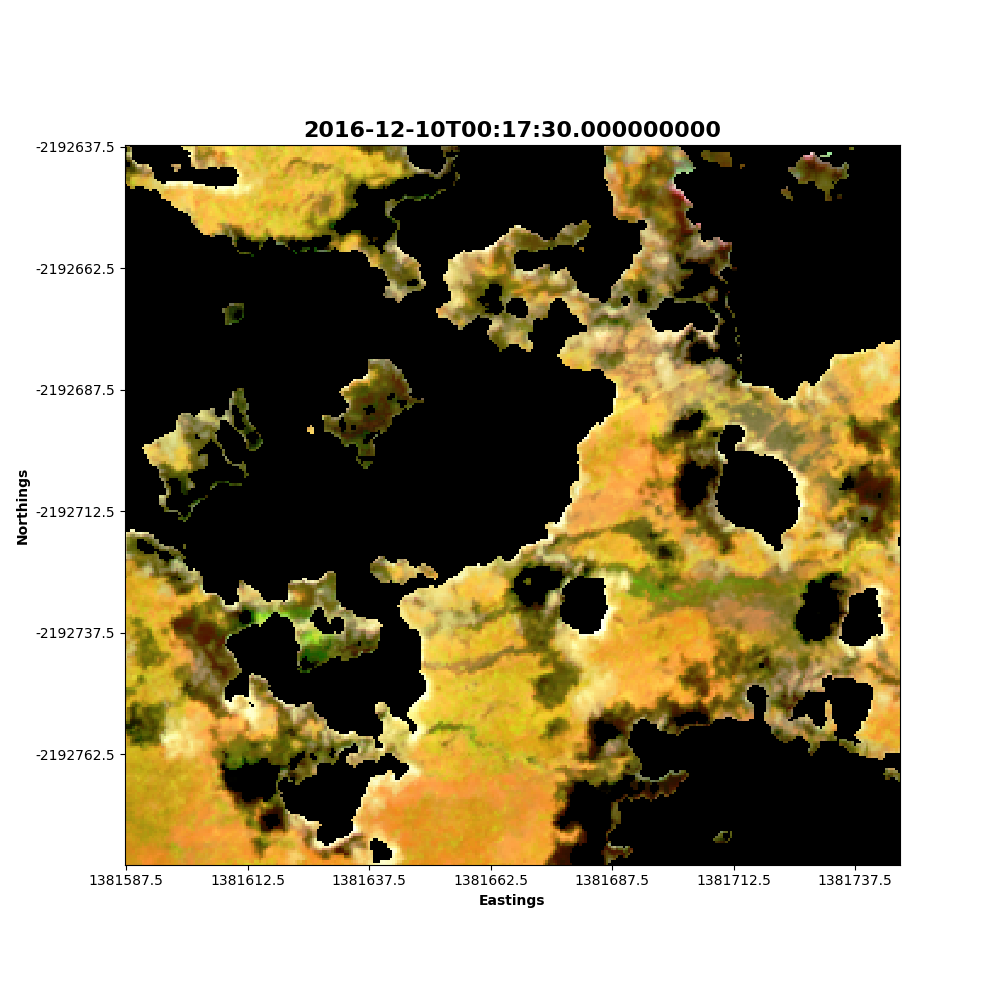

<IPython.core.display.Javascript object>


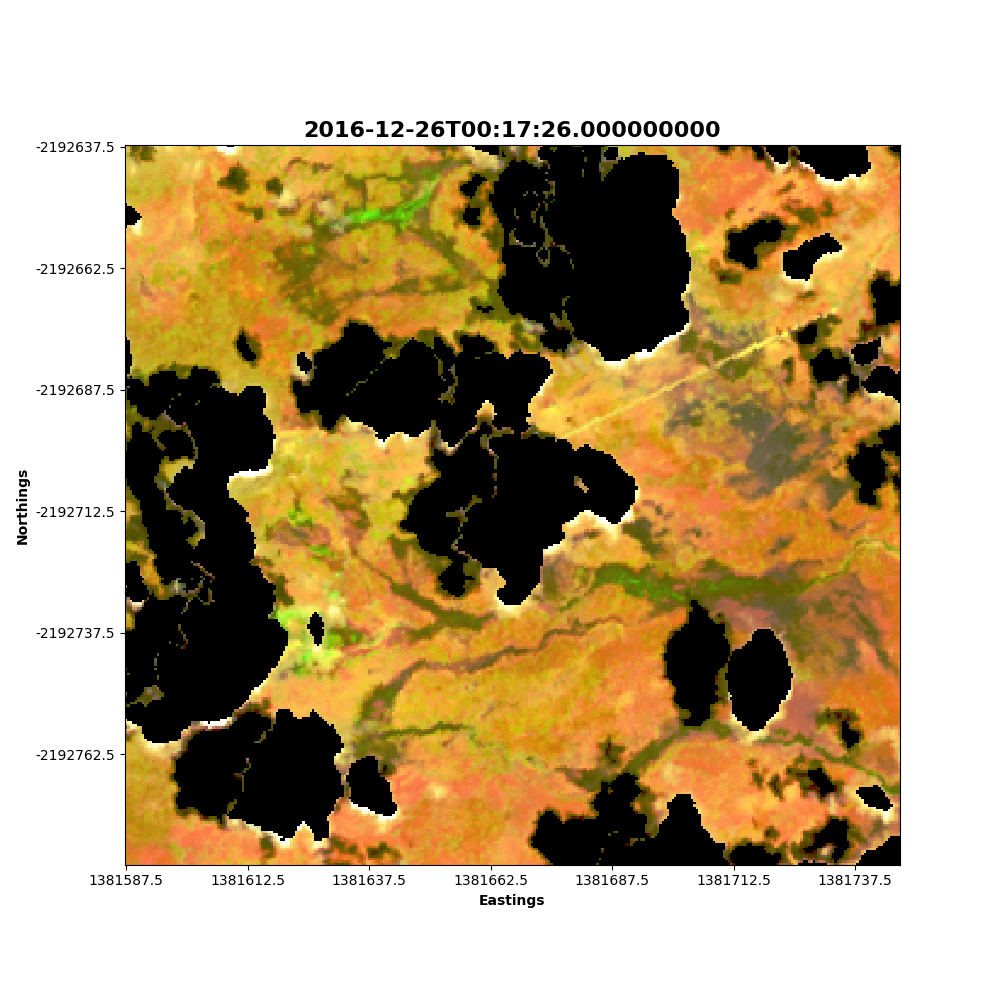

<IPython.core.display.Javascript object>


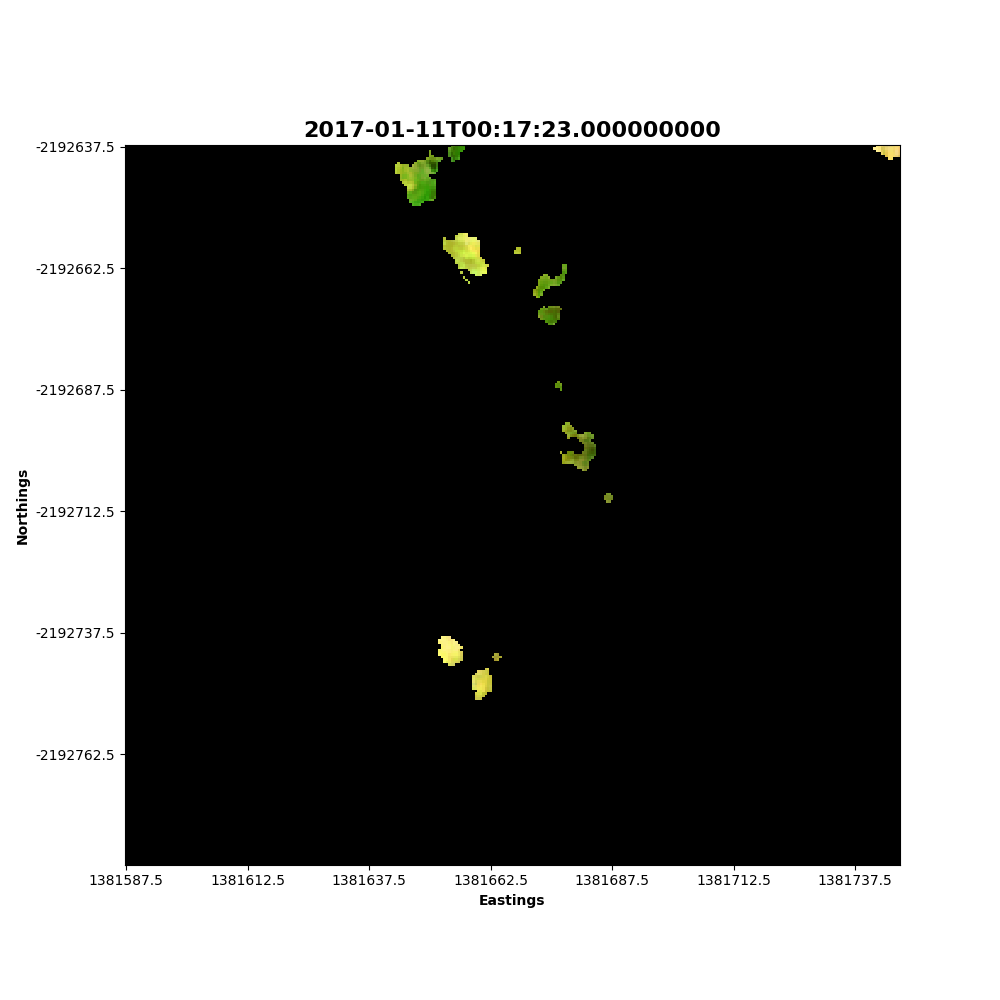

<IPython.core.display.Javascript object>


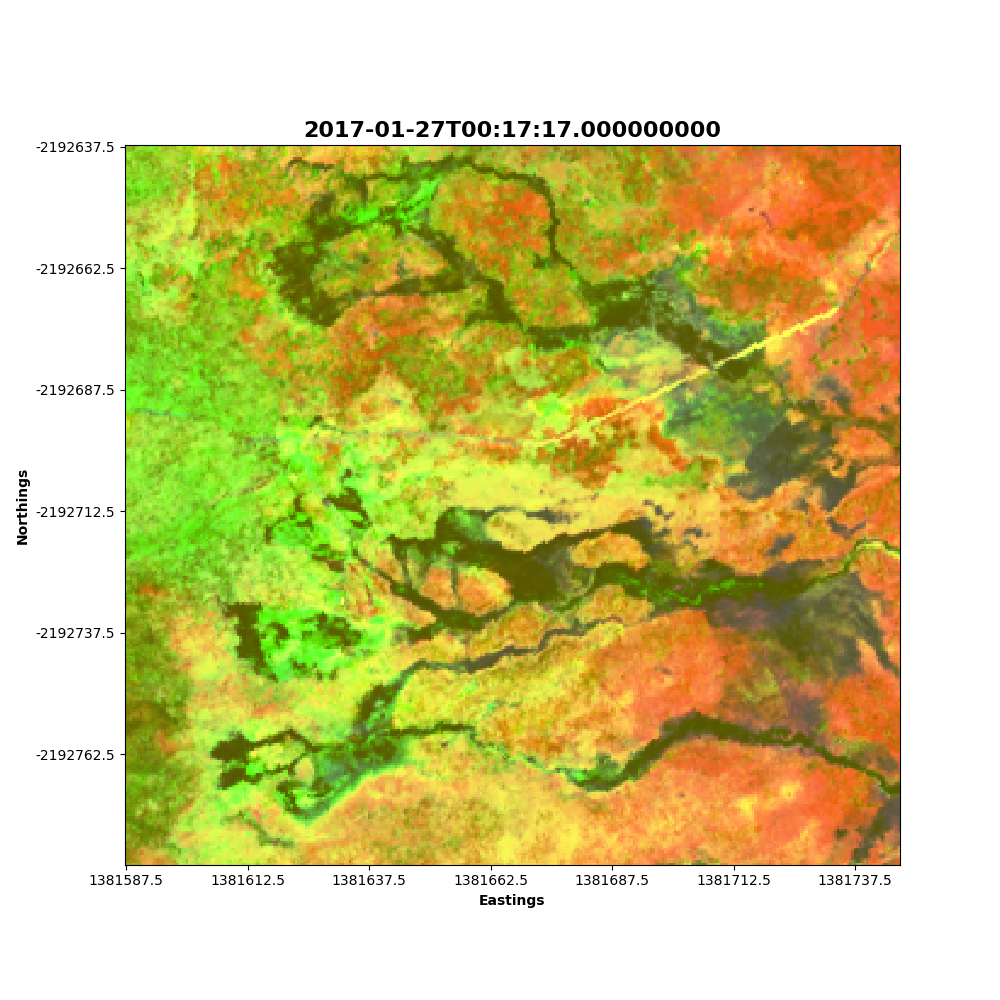

In [21]:
#loops through the data, plots false color images and saves them as individual PNG images
for i in range(0,data.time.size):
    DEAPlotting.three_band_image(data, bands=['swir1', 'nir', 'green'],time =i)
    plt.savefig('./test_image_{}.png'.format(product_time.index[i]))
    plt.show()

## Save as image in netcdf format

### Set a save file name and directory here:

In [16]:
outfile = './test_netcdf.nc'

In [17]:
write_your_netcdf(data.isel(time=0), 'nbar',outfile, crs=crs)

RuntimeError: Storage Unit already exists: test_netcdf.nc


### Write to geotiff as well

In [22]:
DEAPlotting.write_to_geotiff('./test_geotiff.tif', data.isel(time=0))

*** now realise that you didn't change any of the test filenames and feel slightly silly ***